In [35]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

#Load the dataset

df = pd.read_csv('language.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,Text,Language
0,Vikipedi'ye yazılan bilgilerin uygunluğu konus...,Turkish
1,"В отличие от традиционных энциклопедий, таких,...",Russian
2,في المقابلة نفسها، زعم ويلز أيضًا أن عدد المحر...,Arabic
3,Svenskspråkiga Wikipedia var dock i stort sett...,Sweedish
4,അതിനാൽ നിങ്ങൾ യാത്ര ആരംഭിക്കാൻ പോകുകയാണെങ്കിൽ.,Malayalam


### Data Pre-Processing

In [36]:
#eliminating nulls
df = df.dropna()

#to lowercase
df["Text"] = df["Text"].str.lower()

#eliminating @ symbol
df["Text"] = df["Text"].str.replace("@", "")

#eliminating # symbol
df["Text"] = df["Text"].str.replace("#", "")

#eliminating digits
df["Text"] = df["Text"].str.replace("\d", "")

#eliminating whitespaces
df["Text"] = df["Text"].str.replace("\s+", " ")

<ipython-input-36-1051254dabe4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].str.lower()
<ipython-input-36-1051254dabe4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].str.replace("@", "")
<ipython-input-36-1051254dabe4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10237 non-null  object
 1   Language  10237 non-null  object
dtypes: object(2)
memory usage: 239.9+ KB


### Feature Extraction

In [43]:
# FEATURE EXTRACTION USING TF-IDF

# TF-IDF vectorizer object
vectorizer = TfidfVectorizer(max_features=9500)

# Apply the vectorizer to the text
X = vectorizer.fit_transform(df['Text']).toarray()

# Perform Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])


In [44]:
# Split the dataset into training set and testing set
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [45]:
# Retrieve initial labels for languages
language_names = label_encoder.classes_
print(language_names)

['Arabic' 'Danish' 'Dutch' 'English' 'French' 'German' 'Greek' 'Hindi'
 'Italian' 'Kannada' 'Malayalam' 'Portugeese' 'Russian' 'Spanish'
 'Sweedish' 'Tamil' 'Turkish']


### Building the ANN Model

In [59]:
model = Sequential()

# input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# 1st hidden layer
model.add(Dense(32, activation='relu'))

#2nd hidden layer
model.add(Dense(16, activation='relu'))

# output layer
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32)


Epoch 1/40
256/256 [==============================] - 6s 18ms/step - loss: 1.5586 - accuracy: 0.5614 - val_loss: 0.3482 - val_accuracy: 0.9536
Epoch 2/40
256/256 [==============================] - 3s 13ms/step - loss: 0.1876 - accuracy: 0.9648 - val_loss: 0.1592 - val_accuracy: 0.9619
Epoch 3/40
256/256 [==============================] - 3s 13ms/step - loss: 0.0927 - accuracy: 0.9785 - val_loss: 0.1283 - val_accuracy: 0.9673
Epoch 4/40
256/256 [==============================] - 4s 15ms/step - loss: 0.0713 - accuracy: 0.9805 - val_loss: 0.1136 - val_accuracy: 0.9717
Epoch 5/40
256/256 [==============================] - 3s 13ms/step - loss: 0.0654 - accuracy: 0.9816 - val_loss: 0.1148 - val_accuracy: 0.9707
Epoch 6/40
256/256 [==============================] - 4s 14ms/step - loss: 0.0638 - accuracy: 0.9807 - val_loss: 0.1285 - val_accuracy: 0.9644
Epoch 7/40
256/256 [==============================] - 3s 13ms/step - loss: 0.0609 - accuracy: 0.9812 - val_loss: 0.1183 - val_accuracy: 0.9683

### Model Evaluation

In [60]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Loss:", loss)
print("Accuracy:", accuracy)

64/64 [==============================] - 0s 4ms/step - loss: 0.1190 - accuracy: 0.9717
Testing Loss: 0.11900372058153152
Accuracy: 0.9716796875


### Confusion Matrix

In [61]:
#confusion matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Decode the language labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print the confusion matrix
print(confusion_matrix(y_test_decoded, y_pred_decoded))

64/64 [==============================] - 0s 3ms/step
[[104   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0]
 [  0  83   0   0   0   1   0   0   0   0   0   0   1   1   0   0   0]
 [  0   0 106   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   1 278   1   2   0   0   0   0   0   0   0   1   1   0   0]
 [  0   0   1   0 183   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0  94   0   0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   0  71   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0  11   0   0   0   0   1   0   0   0   1]
 [  0   0   0   1   0   1   0   0 136   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  69   0   0   3   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 131   0   3   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0 141   1   4   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0 149   0   0   0   0]
 [  0   0   0   1   2   

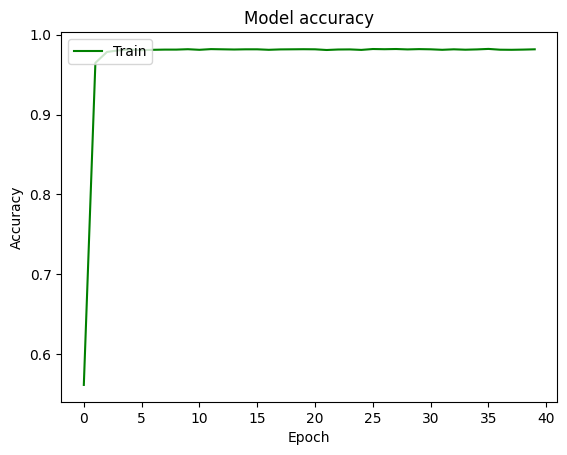

In [62]:
# Plotting a graph of the training process

plt.plot(history.history['accuracy'], color ='green')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


### Testing The Model

In [63]:
# Function to Predict A Language given a customer message

def predict_language(customer_message):
    msg = vectorizer.transform([customer_message]).toarray()

    predicted_label = model.predict(msg)
    predicted_label = np.argmax(predicted_label)

    #Decode the predicted label to get the language
    predicted_language = label_encoder.inverse_transform([predicted_label])

    return predicted_language[0]

In [67]:
msg = input("Enter Your Message: ")

predict_language(msg)

Enter Your Message: Hello. I look forward to the end of all these troubles. 
1/1 [==============================] - 0s 38ms/step


'English'

### Gradio Interface

In [65]:
# installing gradio

!pip install gradio -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.3 MB/s eta 0:

In [66]:
import gradio as gr

iface = gr.Interface(
    fn=predict_language,
    inputs="text",
    outputs="text",
    title="Leo Telecom Language Identification Service",
    description="Predicting the languages of different customer messages for easy 'routing'"
)

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6722953658177a0b52.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
